In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
import os
from collections import Counter
from fbprophet import Prophet

In [2]:
import glob

In [3]:
# count vectorizer
with open('cv1.pickle', 'rb') as f:
    cv1 = pickle.load(f)

# naive bayes multinomial
with open('nb.pickle', 'rb') as f:
    nb = pickle.load(f)

# label encoder
with open('le.pickle', 'rb') as f:
    le = pickle.load(f)

In [143]:
def convert_si(si_unit):
    data = {'mg':1e-3, 'g': 1., 'oz': 28.35, 'ml': 1e-3, 
            'lb': 453.59, 'pound': 453.59,
            'mcg': 1e-6, 'ounce': 28.35, 'kg': 1e3, 'liter': 1e3, 'litre': 1e3}
    return data[si_unit]

def convert_csv_to_prophet(file_path):
    #read csv
    silk_road_df = pd.read_csv(
        file_path, 
        memory_map=True,
        usecols=['price', 'name', 'add_time'],
        dtype={'price':'float64', 'name':'object', 'add_time':'int64'},
        keep_default_na=False
    )
    #text preprocessing
    alphanumeric = lambda x: re.sub(r'\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub(r'[%s]' % re.escape(string.punctuation), ' ', x.lower())
    
    # preprocess text and transform with count vectorizer and predict category
    predicted_categories_dev = nb.predict(cv1.transform(silk_road_df.name.map(alphanumeric).map(punc_lower)))
    # filter only the drugs/prescription category
    #silk_road_df = silk_road_df[predicted_categories_dev==50]
    # get the quantity, weight, and si unit
    size_of_items = silk_road_df.name.str.lower().str.extract(
        r'(?P<quantity>\d*)\s(?P<weight>\d*\.?\d+)\s?(?P<si_unit>kg|g|mg|mcg|oz|ounce|ounces|lb|pound|ml|mcl|liter|litre)')
    # price divided by the quantity of multiplying quantity, weight, and si unit converted to grams
    adj_price = silk_road_df.iloc[size_of_items.dropna().index].price / \
        (size_of_items.dropna().quantity.apply(lambda x: 1 if x=='' else int(x)) \
        * size_of_items.dropna().weight.apply(float) * size_of_items.dropna().si_unit.apply(convert_si))
    # convert to format for prophet
    df_price_time = pd.DataFrame({'adj_price': adj_price, 
                                  'add_time': silk_road_df.iloc[size_of_items.dropna().index].add_time,
                                  'category': predicted_categories_dev[size_of_items.dropna().index]
                                 })
    prophet_transformed = df_price_time[df_price_time['category']==50][['add_time', 'adj_price']]\
        .transform({'add_time': pd.Timestamp.fromtimestamp, 'adj_price': lambda x: x})\
        .rename(columns={'add_time': 'ds', 'adj_price': 'y'})
    quantiles = prophet_transformed.y.quantile([.0001, .95])
    prophet_transformed = prophet_transformed[
        (prophet_transformed.y > quantiles.iloc[0]) & (prophet_transformed.y < quantiles.iloc[1])
        ].replace([np.inf, -np.inf], np.nan)
    prophet_transformed.to_csv(file_path.replace('dnmarchives_rsync_expanded/grams', 'prophet'))
    

In [141]:
convert_csv_to_prophet(
    '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-09/SilkRoad.csv')

In [129]:
grams_csv = glob.glob('/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/*/*.csv')

In [144]:
for file_name in grams_csv:
    convert_csv_to_prophet(file_name)

/Users/jonathandawson/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


In [3]:
prophet_csv = glob.glob('/Volumes/SeagateBlue/ds_data/dark_net_market/prophet/*/*.csv')

In [4]:
len(prophet_csv)

1865

In [20]:
fb_prophet = Prophet()

In [6]:
prophet_df = pd.concat([pd.read_csv(f, memory_map=True) for f in prophet_csv], ignore_index=True)

In [13]:
prophet_df = prophet_df.sample(10000)

In [19]:
quantiles = prophet_df.y.quantile([.0001, .95])
prophet_df = prophet_df[
        (prophet_df.y > quantiles.iloc[0]) & (prophet_df.y < quantiles.iloc[1])
        ]

In [21]:
fb_prophet.fit(prophet_df[['ds','y']])

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/jonathandawson/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [22]:
future = fb_prophet.make_future_dataframe(periods=30)
future.tail()

,ds
9524,2015-08-05 04:58:11
9525,2015-08-06 04:58:11
9526,2015-08-07 04:58:11
9527,2015-08-08 04:58:11
9528,2015-08-09 04:58:11


In [23]:
forecast = fb_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9524,2015-08-05 04:58:11,25.635981,-22.915647,72.534205
9525,2015-08-06 04:58:11,26.797095,-20.947046,75.342194
9526,2015-08-07 04:58:11,24.905163,-22.787554,72.120251
9527,2015-08-08 04:58:11,26.107579,-18.431547,73.207308
9528,2015-08-09 04:58:11,26.295046,-21.587686,71.280805


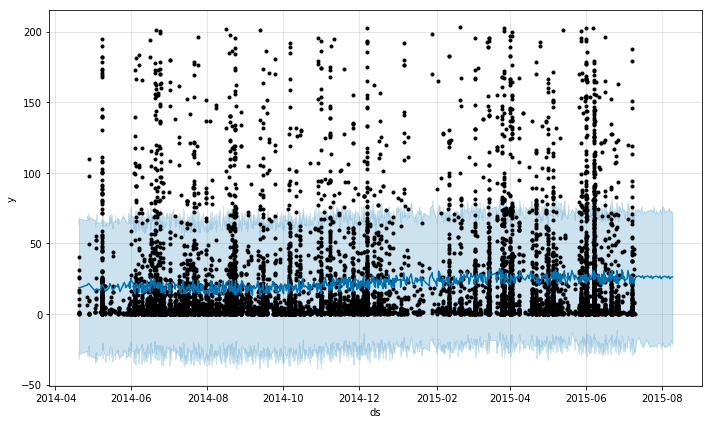

In [24]:
fig1 = fb_prophet.plot(forecast)


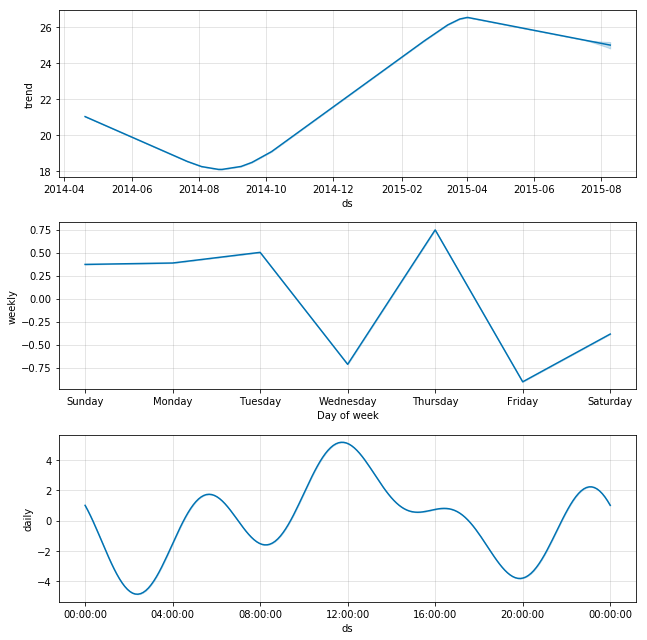

In [25]:
fig = fb_prophet.plot_components(forecast)

In [91]:
# for x in os.listdir('/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/')[1:]:
#     os.mkdir('/Volumes/SeagateBlue/ds_data/dark_net_market/prophet/'+x)

In [76]:
silk_road_df = pd.read_csv(
    '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-09/SilkRoad.csv', 
    memory_map=True,
    usecols=['price', 'name', 'add_time'],
    dtype={'price':'float64', 'name':'object', 'add_time':'int64'})

In [77]:
silk_road_df.dtypes

price       float64
name         object
add_time      int64
dtype: object

In [16]:
"{:03.2f} MB".format(silk_road_df.memory_usage(deep=True).sum() / 1024 ** 2)

'1.33 MB'

In [7]:
type(nb)

sklearn.naive_bayes.MultinomialNB

In [17]:
silk_road_df.name.shape

(12648,)

In [18]:
silk_road_df.name.isna().sum()

0

In [78]:
# text preprocessing
alphanumeric = lambda x: re.sub(r'\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub(r'[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [79]:
# preprocess text and transform with count vectorizer
silkroad_names_cv = cv1.transform(silk_road_df.name.map(alphanumeric).map(punc_lower))

In [80]:
silkroad_names_cv.shape

(12648, 15506)

In [81]:
predicted_categories = nb.predict(silkroad_names_cv)

In [25]:
predicted_categories_dev = nb.predict(cv1.transform(silk_road_df.name.map(alphanumeric).map(punc_lower)))

In [12]:
np.unique(predicted_categories, return_counts=True)

(array([  1,   2,   4,   5,   6,   7,   8,   9,  10,  15,  16,  17,  18,
         20,  21,  22,  23,  24,  26,  27,  28,  29,  30,  31,  34,  35,
         36,  37,  38,  39,  42,  43,  45,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  60,  62,  63,  64,  66,  67,  68,
         70,  73,  74,  78,  79,  80,  81,  82,  86,  88,  89,  90,  91,
         92,  93,  94,  95,  98, 101, 102]),
 array([  28,   60,    2,  283,  215,   57,   44,    2,    7,    8,   36,
           1,    5,  784,  219,   54,  449,   18,  183, 1673,   10,   31,
          79,   14,    7,  870,   73,  721,   45,   13,   71,  133,    4,
           1,   84,   13, 1393,   21,   30,   96,  373,   13,   78,  166,
           3,    7,  499,  636,  655,  171,   73,  234,   70,   73,   33,
          20,    1,    6,   15,   43,    3,  266,  364,   88,  159,   65,
          30,  380,   29,  255,    1,    2]))

In [60]:
silk_road_df[predicted_categories_dev==50].sample(5).name.values

array(['Armodafinil 150mg x 60 tabs ships Globally walkalert',
       '10 X Armodafinil 150mg New verison of Modafinil Blister pack',
       'Uk Domestic Propecia Finesteride 1 mg centurian labs 180 tabs',
       'MODAFINIL MODALERT 200mg 1000 TABLETS SEALED BLISTER PACKS speed tabs',
       'Anastrozole Generic Arimidex 1mg tab 28tabs box'], dtype=object)

In [31]:
# these next three cells show an example of what category the classifier chooses based on the name
silk_road_df.iloc[7230]['name']

'1x 1.5mg Blue Dream alprazolam Xanax tablets NICE'

In [58]:
predicted_categories[7230]

20

In [60]:
le.inverse_transform([20])

array(['Drugs/Benzos'], dtype=object)

In [61]:
le.classes_

array(['Chemicals', 'Counterfeits/Accessories', 'Counterfeits/Clothing',
       'Counterfeits/Electronics', 'Counterfeits/Money',
       'Counterfeits/Watches', 'Data/Accounts', 'Data/Pirated',
       'Data/Software', 'Drug paraphernalia/Containers',
       'Drug paraphernalia/Grinders',
       'Drug paraphernalia/Injecting equipment/Filters',
       'Drug paraphernalia/Injecting equipment/Needles',
       'Drug paraphernalia/Injecting equipment/Other',
       'Drug paraphernalia/Injecting equipment/Syringes',
       'Drug paraphernalia/Paper', 'Drug paraphernalia/Pipes',
       'Drug paraphernalia/Scales', 'Drug paraphernalia/Stashes',
       'Drugs/Barbiturates', 'Drugs/Benzos',
       'Drugs/Cannabis/Concentrates', 'Drugs/Cannabis/Edibles',
       'Drugs/Cannabis/Hash', 'Drugs/Cannabis/Seeds',
       'Drugs/Cannabis/Shake/trim', 'Drugs/Cannabis/Synthetics',
       'Drugs/Cannabis/Weed', 'Drugs/Dissociatives/GBL',
       'Drugs/Dissociatives/GHB', 'Drugs/Dissociatives/Ketamine',
    

In [56]:
le.transform(['Drugs/Weight loss'])

array([69])

In [82]:
size_of_items = silk_road_df.name.str.lower().str.extract(
    r'(?P<quantity>\d*)\s(?P<weight>\d*\.?\d+)\s?(?P<si_unit>kg|g|mg|mcg|oz|ounce|ounces|lb|pound|ml|mcl|liter|litre)')
size_of_items.dropna().shape

(4868, 3)

In [239]:
size_of_items.dropna().quantity.apply(lambda x: 1 if x=='' else int(x))

6        200
7        200
8        200
9         18
10       200
11        18
12       200
13        18
14        18
16       200
17       200
25         1
27         1
28         1
29         1
30         1
31         1
32         1
33         1
34         1
35         1
36         1
37         1
38         1
39         1
40         1
41         1
42         1
43         1
45         1
        ... 
12551    200
12552    200
12554    200
12561    200
12562    200
12565    200
12566    200
12567    200
12569    200
12572    200
12573    200
12574    200
12575    200
12576    200
12577    200
12578    200
12580    200
12581    200
12586      5
12588      1
12589      1
12593     10
12598      5
12601      5
12603      1
12604      1
12605      1
12606     56
12616      1
12627      1
Name: quantity, Length: 4868, dtype: int64

In [228]:
def convert_si(si_unit):
    data = {'mg':1e-3, 'g': 1., 'oz': 28.35, 'ml': 1e-3, 
            'lb': 453.59, 'pound': 453.59,
            'mcg': 1e-6, 'ounce': 28.35, 'kg': 1e3, 'liter': 1e3}
    return data[si_unit]

In [84]:
silk_road_df.dtypes

price       float64
name         object
add_time      int64
dtype: object

In [83]:
# price divided by the quantity of multiplying quantity, weight, and si unit converted to grams
adj_price = silk_road_df.iloc[size_of_items.dropna().index].price / \
    (size_of_items.dropna().quantity.apply(lambda x: 1 if x=='' else int(x)) \
    * size_of_items.dropna().weight.apply(float) * size_of_items.dropna().si_unit.apply(convert_si))
# return the dataframe of the adj price, category, and add_time
pd.DataFrame({'adj_price': adj_price,
              'category': predicted_categories[size_of_items.dropna().index],
              'add_time': silk_road_df.iloc[size_of_items.dropna().index].add_time
             }
            ).shape

(4868, 3)

In [268]:
adj_price.shape

(4868,)

In [73]:
silk_road_df.name.head(30).values

array(['Extra shipping for custom order', '220 FE Only TW X MB',
       'BUY BITCOINS WITH NETSPEND RELOAD',
       'BUY BITCOINS WITH MONEYGRAM OR WESTERN UNION',
       '1000mg 2C B HCl pure', '1 gram MDMA crystals 83 pure',
       '1x Bugatti 200 220mg MDMA', '1x Blue Android 200 220mg MDMA',
       '3x Blue Androids 200 220mg MDMA', '10x 18 20mg 2C B HCl caps',
       '5x Blue Androids 200 220mg MDMA', '5x 18 20mg 2C B HCl caps',
       '25x Blue Androids 200 220mg MDMA', '3x 18 20mg 2C B HCl caps',
       '1x 18 20mg 2C B HCl caps', '5 grams MDMA crystals 83 pure',
       '25x Bugattis 200 220mg MDMA', '3x Bugattis 200 220mg MDMA',
       '3 grams MDMA crystals 83 pure', '20gr Pure MDMA Crystals 84',
       '10gr Pure MDMA Crystals 84', 'Mollies in capsules pure MDMA',
       '1 oz of Crystal Meth', 'Half Gram of Crystal Meth',
       '1.75 grams of Crystal Meth', 'Ball of Crystal Meth 3.5grams',
       '1 gram of Crystal Meth', '1 4 oz of Crystal Meth',
       'SCIROXX Primodex 1

In [136]:
silk_road_df.head(30)

,hash,market_name,item_link,vendor_name,price,name,description,image_link,add_time,ship_from,Unnamed: 10
0,2-2509,Silk Road 2,http://silkroad6ownowfk.onion/items/extra-ship...,$220for28grams,0.000017,Extra shipping for custom order,Extra Shipping for custom order. If you don t ...,NaN,1402306960,United States,NaN
1,2-11922,Silk Road 2,http://silkroad6ownowfk.onion/items/220-fe-onl...,$220for28grams,0.337382,220 FE Only TW X MB,1oz of the same tw x mb as my other listing FE...,NaN,1401874137,United States,NaN
2,2-30410,Silk Road 2,http://silkroad6ownowfk.onion/items/buy-bitcoi...,*REALDEAL*,0.000000,BUY BITCOINS WITH NETSPEND RELOAD,BUY BITCOINS WITH NETSPEND RELOAD LEAVE THE FO...,2-30410,1401864341,United States,NaN
3,2-38280,Silk Road 2,http://silkroad6ownowfk.onion/items/buy-bitcoi...,*REALDEAL*,0.000000,BUY BITCOINS WITH MONEYGRAM OR WESTERN UNION,DUE TO THE CRACK DOWN ON THE PREPAID CREDIT CA...,2-38280,1401887490,United States,NaN
4,2-6786,Silk Road 2,http://silkroad6ownowfk.onion/items/1000mg-2c-...,03welle,0.247126,1000mg 2C B HCl pure,The effects of 2C B are often described as a c...,2-6786,1402304534,Germany,NaN
5,2-33551,Silk Road 2,http://silkroad6ownowfk.onion/items/1-gram-mdm...,03welle,0.068507,1 gram MDMA crystals 83 pure,Usual doses of MDMA range from around 80 to 16...,2-33551,1401865121,Germany,NaN
6,2-37647,Silk Road 2,http://silkroad6ownowfk.onion/items/1x-bugatti...,03welle,0.016484,1x Bugatti 200 220mg MDMA,The successors of the popular Dominos Strong a...,2-37647,1401865065,Germany,NaN
7,2-37644,Silk Road 2,http://silkroad6ownowfk.onion/items/1x-blue-an...,03welle,0.016459,1x Blue Android 200 220mg MDMA,The successors of the Yellow Bitcoins Clean an...,2-37644,1401863523,Germany,NaN
8,2-37643,Silk Road 2,http://silkroad6ownowfk.onion/items/3x-blue-an...,03welle,0.046209,3x Blue Androids 200 220mg MDMA,The successors of the Yellow Bitcoins Clean an...,2-37643,1401862862,Germany,NaN
9,2-6271,Silk Road 2,http://silkroad6ownowfk.onion/items/10x-18-20m...,03welle,0.110308,10x 18 20mg 2C B HCl caps,Hey everyone we are thinking about broadening ...,2-6271,1401860893,Germany,NaN


In [161]:
le.transform(['Other'])

array([91])

In [165]:
silk_road_df.vendor_name.nunique()

688

In [178]:
files = []
for root, dirs, file in os.walk('/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams'):
    files.append((root, dirs, file))

In [180]:
len(files)

265

In [197]:
Counter([y for x in files[11:] for y in x[2]])

Counter({'1776.csv': 1,
         'ADM.csv': 79,
         'Agora.csv': 247,
         'BB.csv': 205,
         'Bungee54.csv': 96,
         'C9.csv': 94,
         'EVO.csv': 172,
         'Pandora.csv': 46,
         'SilkRoad.csv': 85,
         'TPM.csv': 76,
         'ME.csv': 222,
         'TOM.csv': 45,
         'Alpaca.csv': 41,
         'OutLaw.csv': 143,
         'EVO2.csv': 25,
         'NK.csv': 107,
         'Alpha.csv': 76,
         'Abraxas.csv': 42,
         'Haven.csv': 12,
         'Oxygen .csv': 27,
         'Silkkitie.csv': 24})

In [202]:
silk_road_file_path = []
for root, dirs, file in files:
    if 'SilkRoad.csv' in file:
        silk_road_file_path.append(root+'/'+'SilkRoad.csv')

In [203]:
silk_road_file_path

['/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-09/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-11/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-11-2/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-12/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-13/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-14/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-15/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-16/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-17/SilkRoad.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_mark

In [300]:
silk_road_full_df = pd.concat([pd.read_csv(f, memory_map=True) for f in silk_road_file_path], ignore_index=True)

In [301]:
silk_road_full_df.shape

(810721, 11)

In [211]:
silk_road_full_df.memory_usage(index=True, deep=True).sum()

1261060625

In [212]:
1261060625/1000000

1261.060625

In [302]:
silkroad_names_cv_full = cv1.transform(silk_road_full_df.name.map(alphanumeric).map(punc_lower))
predicted_categories_full = nb.predict(silkroad_names_cv_full)

In [303]:
regex_quantity_weight_unit = r'(?P<quantity>\d*)\s(?P<weight>\d*\.?\d+)\s?(?P<si_unit>kg|g|mg|mcg|oz|ounce|ounces|lb|pound|ml|mcl|liter|litre)'
size_of_items_full = silk_road_full_df.name.str.lower().str.extract(regex_quantity_weight_unit)

In [304]:
adj_price_full = silk_road_full_df.iloc[size_of_items_full.dropna().index].price / \
    (size_of_items_full.dropna().quantity.apply(lambda x: 1 if x=='' else int(x)) \
     * size_of_items_full.dropna().weight.apply(float) \
     * size_of_items_full.dropna().si_unit.apply(convert_si)
    )

In [306]:
silkroad_full_price_cat_time = \
pd.DataFrame({'adj_price': adj_price_full,
              'category': predicted_categories_full[size_of_items_full.dropna().index],
              'add_time': silk_road_full_df.iloc[size_of_items_full.dropna().index].add_time
             }
            )

In [307]:
silkroad_full_price_cat_time.category.value_counts()

50    69356
20    39867
37    37226
27    35260
63    31754
35    14841
62    12937
64     8290
23     7876
26     6938
21     6164
68     4389
54     4051
66     3967
57     3803
48     3128
67     3108
56     2082
22     1944
43     1856
30     1640
36     1501
7      1314
42     1271
38     1200
53     1129
70      991
52      846
51      675
6       667
94      661
31      569
34      510
29      473
39      452
98      432
45      368
58      343
49      263
89      225
28      184
88      128
60       78
91       77
69       69
5        66
24       55
47       49
59       32
17       30
72       30
8        24
44        7
Name: category, dtype: int64

In [338]:
le.inverse_transform([50])

array(['Drugs/Prescription'], dtype=object)

In [327]:
prophet_transformed = silkroad_full_price_cat_time[silkroad_full_price_cat_time.category==50][
    ['add_time', 'adj_price']
].transform({'add_time': pd.Timestamp.fromtimestamp, 'adj_price': lambda x: x})\
.rename(columns={'add_time': 'ds', 'adj_price': 'y'})

In [364]:
quantiles = prophet_transformed.y.quantile([.0001, .95])
quantiles

0.0001      0.0000
0.9500    309.7922
Name: y, dtype: float64

In [371]:
prophet_transformed = prophet_transformed[
    (prophet_transformed.y > quantiles.iloc[0]) & (prophet_transformed.y < quantiles.iloc[1])
]

In [373]:
fb_prophet = Prophet()

In [374]:
fb_prophet.fit(prophet_transformed.replace([np.inf, -np.inf], np.nan))

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/jonathandawson/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [375]:
future = fb_prophet.make_future_dataframe(periods=30)
future.tail()

,ds
65890,2014-11-26 10:24:54
65891,2014-11-27 10:24:54
65892,2014-11-28 10:24:54
65893,2014-11-29 10:24:54
65894,2014-11-30 10:24:54


In [376]:
forecast = fb_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
65890,2014-11-26 10:24:54,26.800872,-32.713605,80.769317
65891,2014-11-27 10:24:54,18.387346,-42.503287,77.436267
65892,2014-11-28 10:24:54,20.098606,-37.724226,82.121784
65893,2014-11-29 10:24:54,14.905430,-47.168223,77.136875
65894,2014-11-30 10:24:54,20.976613,-39.228527,82.566931


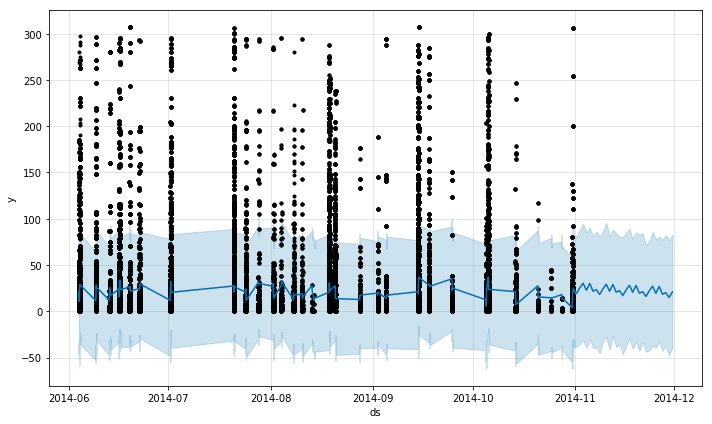

In [377]:
fig1 = fb_prophet.plot(forecast)


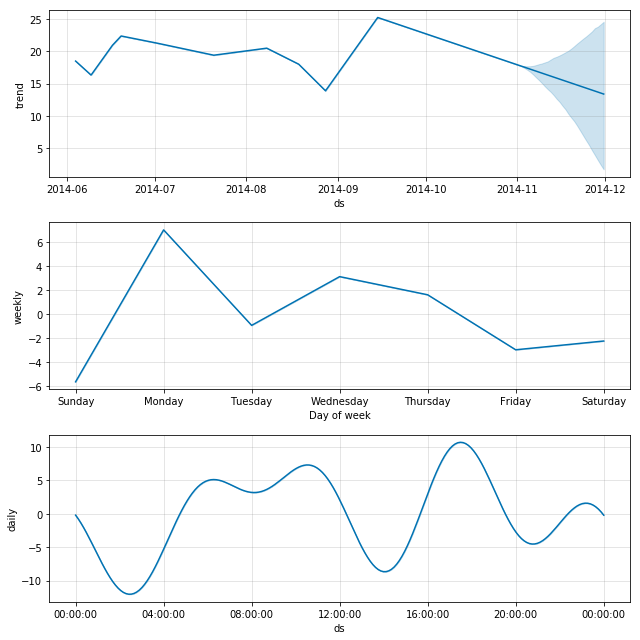

In [378]:
fig = fb_prophet.plot_components(forecast)

In [18]:
grams_csv[:5]

['/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-09/1776.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-09/ADM.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-09/Agora.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-09/BB.csv',
 '/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/2014-06-09/Bungee54.csv']

In [19]:
grams_df = pd.concat([pd.read_csv(
    f, 
    memory_map=True,
    usecols=['price', 'name', 'add_time'],
    dtype={'price':'float64', 'name':'object', 'add_time':'int64'}) for f in grams_csv], 
                              ignore_index=True)

In [20]:
grams_df.shape

(12384326, 3)

In [21]:
"{:03.2f} MB".format(grams_df.memory_usage(deep=True).sum() / 1024 ** 2)

'1285.54 MB'

In [25]:
grams_df.isna().sum()

price          0
name        8999
add_time       0
dtype: int64

In [27]:
grams_df.dropna(inplace=True)
grams_df.shape

(12375327, 3)

In [7]:
import dask.dataframe as dd

In [8]:
df = dd.read_csv('/Volumes/SeagateBlue/ds_data/dark_net_market/dnmarchives_rsync_expanded/grams/*/*.csv',
                 usecols=['price', 'name', 'add_time'],
                 dtype={'price':'float64', 'name':'object', 'add_time':'int64'},
                 parse_dates=['add_time'])

In [4]:
df.head(5)

,price,name,add_time
0,50.00,1 gr indian Ketamin,1399918210
1,0.25,Get Yer Bitcoins Here My BTC for your Reloads,1399572372
2,225.00,1oz Vintage 2006 AAA Greenhouse BC Bud,1401051987
3,360.00,1 8oz AAA Critical Plus BC Bud Greenhouse,1401051986
4,200.00,1oz AAA Critical Plus BC Bud Greenhouse,1401051986


In [7]:
len(df)

12384326

In [ ]:
from dask.distributed import Client

In [9]:
client = Client()

In [10]:
df = df.dropna()

In [11]:
transformed_df = df.name.map(alphanumeric).map(punc_lower)

In [12]:
predicted_categories_df = nb.predict(cv1.transform(transformed_df))

NotImplementedError: 

In [ ]:
df = df[predicted_categories_df == 50]

In [ ]:
size_of_items = df.name.str.lower().str.extract(
    r'(?P<quantity>\d*)\s(?P<weight>\d*\.?\d+)\s?(?P<si_unit>kg|g|mg|mcg|oz|ounce|ounces|lb|pound|ml|mcl|liter|litre)')


In [ ]:
size_of_items = size_of_items.dropna()

In [ ]:
def convert_si(si_unit):
    data = {'mg':1e-3, 'g': 1., 'oz': 28.35, 'ml': 1e-3, 
            'lb': 453.59, 'pound': 453.59,
            'mcg': 1e-6, 'ounce': 28.35, 'kg': 1e3, 'liter': 1e3}
    return data[si_unit]

In [ ]:
# price divided by the quantity of multiplying quantity, weight, and si unit converted to grams
adj_price = df.iloc[size_of_items.index].price / \
    (size_of_items.quantity.apply(lambda x: 1 if x=='' else int(x)) \
    * size_of_items.weight.apply(float) * size_of_items.si_unit.apply(convert_si))

In [ ]:
df_price_cat_time = \
dd.DataFrame({'adj_price': adj_price,
              'category': predicted_categories_df[size_of_items.index],
              'add_time': df.iloc[size_of_items.index].add_time
             }
            )

In [ ]:
prophet_transformed = df_price_cat_time[['add_time', 'adj_price']]\
.transform({'add_time': pd.Timestamp.fromtimestamp, 'adj_price': lambda x: x})\
.rename(columns={'add_time': 'ds', 'adj_price': 'y'})

In [ ]:
quantiles = prophet_transformed.y.quantile([.0001, .95])

In [ ]:
prophet_transformed = prophet_transformed[
    (prophet_transformed.y > quantiles.iloc[0]) & (prophet_transformed.y < quantiles.iloc[1])
].replace([np.inf, -np.inf], np.nan)

In [ ]:
prophet_transformed.to_hdf('output-*.hdf', '/Volumes/SeagateBlue/ds_data/dark_net_market/prophet')